# Multivariate Gaussian Distributions

We often encounter multivariate normal or Gaussian distributions (MND), for example as the output from a fit to a data sample that returns mean and covariance matrix of the estimator for the optimal parameter vector.

In this Jupyter notebook we are going to sample a MND, for example to explore the effects that random fluctuations would have on such a fit result.

We can for example look at the result of a straight line fit from the section on fitting. We found the best estimate and covariance matrix for the line parameters of
$$
\vec{\mu}
=
\left(\begin{array}{c}
4.16 \\ 0.63 
\end{array}\right)
\qquad
\mathbf{\Sigma}
=
\left(\begin{array}{c}
1.58 & -0.209 \\ -0.209 & 0.037
\end{array}\right)
$$



![chi2 distribution of straight line fit](cxy.png)
![chi2 distribution of straight line fit](cchi2.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
mu = np.array( [4.16,0.63] )
cov = np.array( [[1.58,-0.209],[-0.209,0.037]] )

print("Mean: ", mu)
print("Covariance matrix:")
pprint(cov)

Mean:  [4.16 0.63]
Covariance matrix:
array([[ 1.58 , -0.209],
       [-0.209,  0.037]])


# First attempt

A crude approach to sampling the MND is to first generate $X$, use this to calculate the expectation value for $Y$ and draw samples from a normal distribution with this mean.

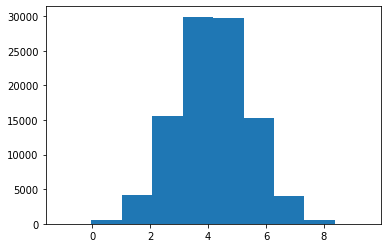

In [3]:
x = np.random.normal(mu[0],np.sqrt(cov[0,0]),size=100000)
plt.hist(x);

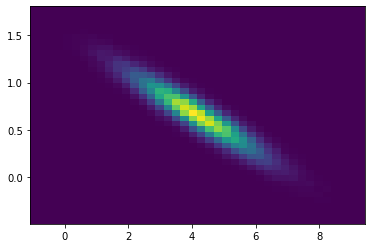

In [4]:
y = np.random.normal(1.5 - 0.2*x, 0.1)
# plt.hist(y);

plt.hist2d(x,y ,bins=[40,40]);

But how can we tune the slope, offset and standard deviation in the sampling of $Y$ values? You can read them off the $\chi^2$ plot for the parameter space shown above, and refine by trial and error

Try and see what effect a change of the parameters in the cell above has. 

# Sampling via scaling and rotation

If we can determine the angle and the axes of the elliptic contours that represent our covariance matrix, then we can find reconstruct the covariance matrix. This is actually an eigenvalue problem - and we will use the numpy.linalg function eig to do that for us. We can see that there is a simple alter

In [5]:
w,v = np.linalg.eig(cov)

U = np.array(v).transpose()
D = np.diag(w)

A = np.diag( 1 / np.sqrt(w))
AT = A.transpose()
UT = U.transpose()

print("Diagonal matrix with eigenvalues D\n", D, '\n')
# print("Inverse of diagonal matrix D^{-1}\n", np.linalg.inv(D), '\n')

print("Unitary rotation matrix U\n", U, '\n')
print("Approximated covariance matrix UT*D*U\n", UT@D@U, '\n')
print("Correct covariance matrix\n", cov, '\n')

print("Inverse of the covariance matrix\n", np.linalg.inv(cov), '\n')
print("Alternative calculation UT.A.A.U\n", UT@A@A@U, '\n')

Diagonal matrix with eigenvalues D
 [[1.60780798 0.        ]
 [0.         0.00919202]] 

Unitary rotation matrix U
 [[ 0.99126433 -0.13189024]
 [ 0.13189024  0.99126433]] 

Approximated covariance matrix UT*D*U
 [[ 1.58  -0.209]
 [-0.209  0.037]] 

Correct covariance matrix
 [[ 1.58  -0.209]
 [-0.209  0.037]] 

Inverse of the covariance matrix
 [[  2.50355234  14.14168753]
 [ 14.14168753 106.90845118]] 

Alternative calculation UT.A.A.U
 [[  2.50355234  14.14168753]
 [ 14.14168753 106.90845118]] 



## Visualizing the PDF

In the following, we will visualize the PDF for different multi-variate normal distributions. We will start with our goal, the PDF for the specified mean $\vec{\mu}$ and covariance matrix $\Sigma$. We will then reproduce this PDF, starting from a standard normal distribution that we stretch, rotate and translate.

We define a function that takes care of the plotting for us.

In [6]:
def plot_contours(func):

    aa = np.linspace(-6,11,100)
    bb = np.linspace(-7,6,100)
    a,b = np.meshgrid(aa,bb)

    ff = np.vectorize( lambda a,b: np.sqrt(func(np.array( [a,b]))) ) (a,b)
    
    plt.contour(aa,bb,ff, levels=np.linspace(0,5,6))
    
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    

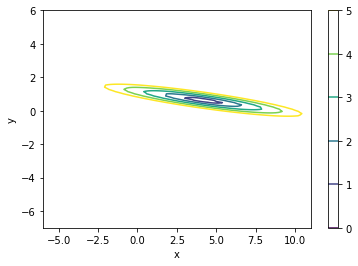

In [7]:
def func_cov(x):
    return (x-mu) @ np.linalg.inv(cov) @ (x-mu)

plot_contours(func_cov)

# Starting point: standard normal distribution

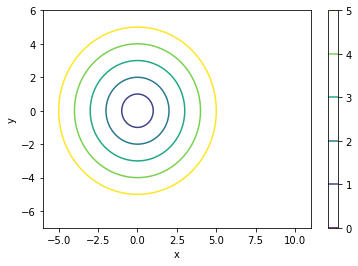

In [8]:
plot_contours(lambda x: x@x)

# Scaling

We first scale the standard normal distribution by the eigenvalues of the covariance matrix. This reproduces the shape of the contour lines, but not the orientation or position.

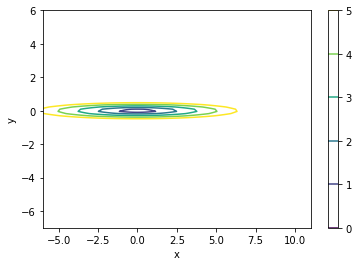

In [9]:
plot_contours(lambda x: x @ AT@A @ x )

# Rotation

As the next step we rotate the contour lines by multiplying with the unitary matrices.

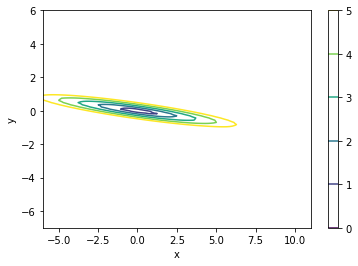

In [10]:
plot_contours(lambda x: x @ UT@AT@A@U @ x )

# Scaling + Rotation + Translation

And finally we check that we can reproduce the original contour lines when we include the translation my the expectation value $\vec{\mu}$.

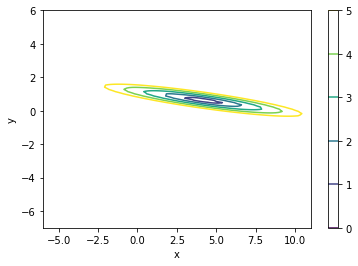

In [11]:
plot_contours(lambda x: (x-mu) @ UT@AT@A@U @ (x-mu) )

The trick is now to recognize that this can be interpreted as a standard normal distribution
$$
(x-\mu)^T\,U^TA^TAU\,(x-\mu) 
= \big(AU\,(x-\mu)\big)^T\,\big(AU\,(x-\mu)\big)
= y^T y
$$

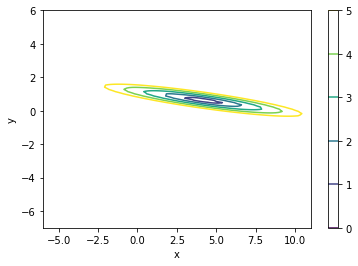

In [12]:
plot_contours(lambda x: ( A@U @ (x-mu) ) @ ( A@U @ (x-mu) ))

# Sampling $N(\mu,\Sigma)$

We know that the random vector $y \sim N(0,1)$ is standard normally distributed. Solving for $x$ then gives us a $N(\mu,\Sigma)$ distributed vector:
$$
x = \mu + U^T\,A^{-1}\,y
$$

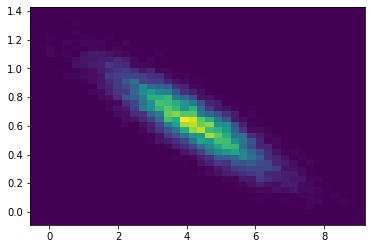

In [13]:
y = np.random.normal(size=[2,10000])
x = np.dot( UT @ np.sqrt(D) ,y)

plt.hist2d(x[0]+mu[0],x[1]+mu[1] ,bins=[40,40]);

## Alternative: Cholesky Decomposition

In the final step of the sampling via the diagonalization of the matrix, we only used that we can write the covariance matrix as a product of a matrix and its transpose. That means that any decomposition
$$
\Sigma = M^T\,M
$$
Will give the same result. The Cholesky algorithm provides such a decomposition.

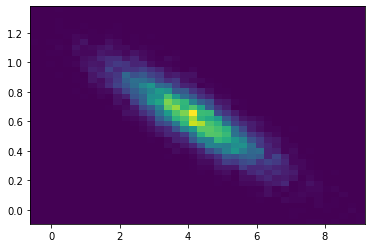

In [14]:
y = np.random.normal(size=[2,10000])
x = np.dot( np.linalg.cholesky(cov) ,y)

plt.hist2d(x[0]+mu[0],x[1]+mu[1] ,bins=[40,40]);